In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import seaborn as sns

In [9]:
TRAIN_DIR = '/content/drive/MyDrive/MRI Images/Training/'
TEST_DIR = '/content/drive/MyDrive/MRI Images/Testing/'

In [10]:
def get_image_paths(base_dir):
    paths, labels = [], []
    for category in os.listdir(base_dir):
        folder = os.path.join(base_dir, category)
        for img in os.listdir(folder):
            paths.append(os.path.join(folder, img))
            labels.append(category)
    return shuffle(paths, labels)

train_files, train_labels = get_image_paths(TRAIN_DIR)
test_files, test_labels = get_image_paths(TEST_DIR)
print(f"Loaded {len(train_files)} training and {len(test_files)} testing images.")

Loaded 5712 training and 1311 testing images.


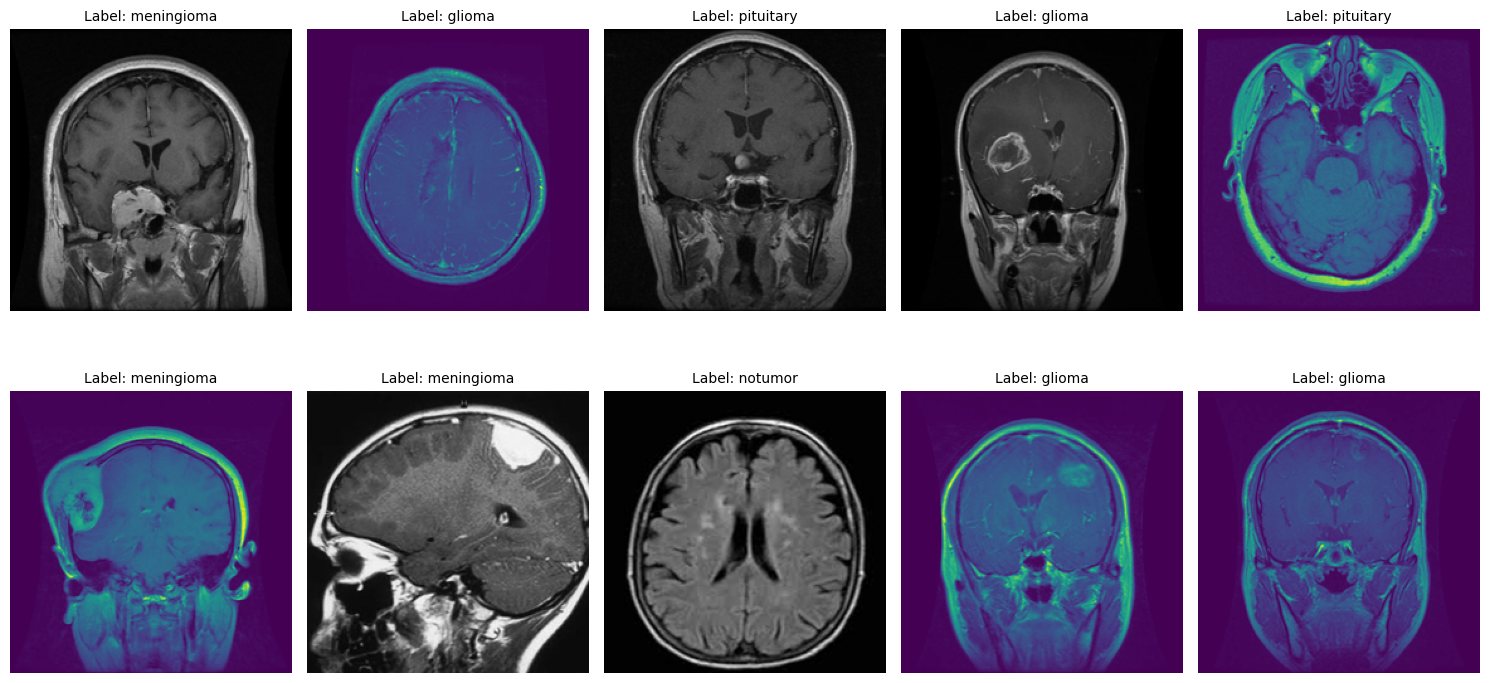

In [11]:
def preview_random_images(image_paths, image_labels, num_samples=10):
    indices = random.sample(range(len(image_paths)), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()

    for idx, i in enumerate(indices):
        img = Image.open(image_paths[i]).resize((224, 224))
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Label: {image_labels[i]}", fontsize=10)

    plt.tight_layout()
    plt.show()

preview_random_images(train_files, train_labels)

In [12]:
def enhance_image_quality(img):
    img = Image.fromarray(np.uint8(img))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.85, 1.15))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.85, 1.15))
    return np.array(img) / 255.0

def prepare_images(image_list, target_size=128):
    data = []
    for path in image_list:
        image = load_img(path, target_size=(target_size, target_size))
        data.append(enhance_image_quality(image))
    return np.array(data)

def encode_labels(labels, base_path):
    class_names = sorted(os.listdir(base_path))
    return np.array([class_names.index(lbl) for lbl in labels])

In [13]:
def batch_generator(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_imgs = prepare_images(paths[i:i+batch_size])
            batch_lbls = encode_labels(labels[i:i+batch_size], TRAIN_DIR)
            yield batch_imgs, batch_lbls

In [14]:
IMAGE_SIZE = 128
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze all layers except last 3
for layer in base_model.layers[:-3]:
    layer.trainable = False

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(TRAIN_DIR)), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 5,768,836 (22.01 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [15]:
BATCH_SIZE = 20
EPOCHS = 5
STEPS_PER_EPOCH = len(train_files) // BATCH_SIZE

history = model.fit(
    batch_generator(train_files, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1835s 6s/step - loss: 0.6687 - sparse_categorical_accuracy: 0.7446
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1284s 5s/step - loss: 0.2710 - sparse_categorical_accuracy: 0.9011
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1287s 5s/step - loss: 0.1837 - sparse_categorical_accuracy: 0.9330
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1283s 4s/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9469
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1282s 4s/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9630


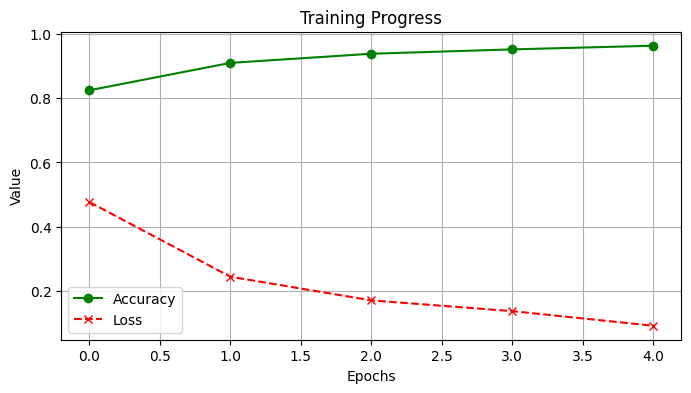

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['sparse_categorical_accuracy'], 'g-', marker='o', label='Accuracy')
plt.plot(history.history['loss'], 'r--', marker='x', label='Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 260s 6s/step
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       300
           1       0.93      0.87      0.90       306
           2       0.96      0.99      0.97       405
           3       0.99      0.95      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



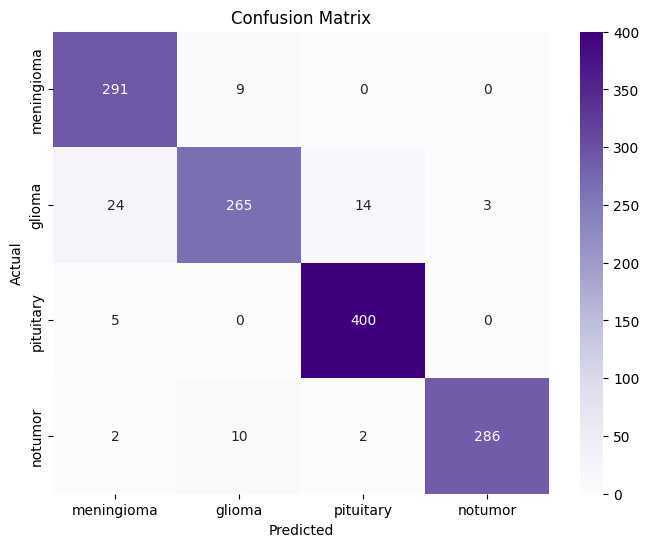

In [17]:
test_imgs = prepare_images(test_files)
test_lbls_encoded = encode_labels(test_labels, TRAIN_DIR)
predictions = model.predict(test_imgs)

print("Classification Report:\n")
print(classification_report(test_lbls_encoded, np.argmax(predictions, axis=1)))

# Confusion Matrix
cm = confusion_matrix(test_lbls_encoded, np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=os.listdir(TRAIN_DIR),
            yticklabels=os.listdir(TRAIN_DIR))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


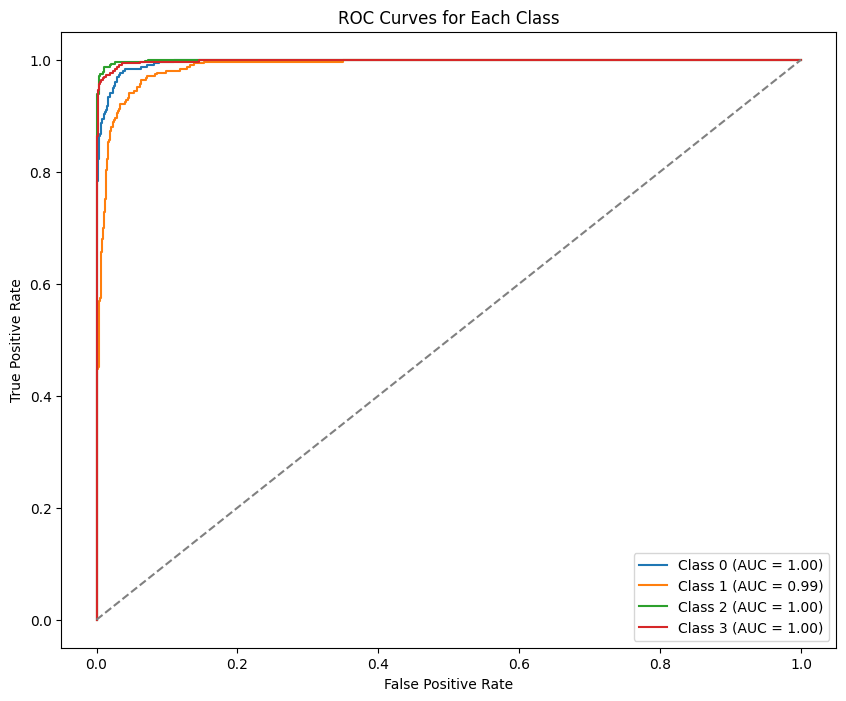

Model saved as 'brain_tumor_vgg16.h5' successfully!


In [19]:
from sklearn.preprocessing import label_binarize

classes = len(os.listdir(TRAIN_DIR))
binarized_labels = label_binarize(test_lbls_encoded, classes=np.arange(classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Save model
model.save('brain_tumor_vgg16.h5')
print("Model saved as 'brain_tumor_vgg16.h5' successfully!")
